## <font style='font-size: 30px;'> Avaliação do modelo de segunda ordem </font> <hr style='line: 2px solid;'>

A função de transferência média da planta de pressão é dada por, segundo a análise feita é:

$$
\zeta = 0.3346 \\
\omega_n = 4.4971 \\
k = 1.3885
$$

O que nos dá a seguinte função transferência:

$$
G(s) \approx 1.3885 \cdot \frac{20.223}{s^2 + 3s + 20.223}
$$

É uma função de segunda ordem com a seguinte resposta:

                    Valor
Parâmetro                
RiseTime           0.1799
SettlingTime       2.4825
SettlingMin        0.4367
SettlingMax        0.8715
Overshoot         49.9097
Undershoot         0.0000
Peak               0.8715
PeakTime           0.4677
SteadyStateValue   0.5813


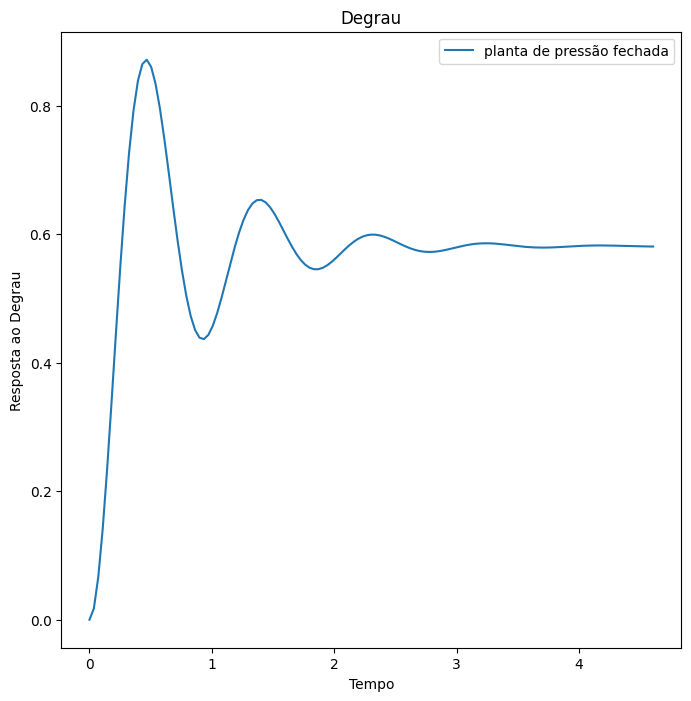

In [2]:
planta_pressao = ct.TransferFunction([28.0796],[1, 3, 20.223])
planta_pressao_fechada = ct.feedback(planta_pressao, 1)
parametros = obter_plot_degrau({'planta de pressão fechada':planta_pressao_fechada}, amortecimento=0.02)
parametros

requisitos definidos:

- $e_{ss} = 0.02$
- $T_s(2\%) < 1s$
- $M_p < 20 \%$

> 1. Encontre um ganho para garantir seu erro e verifique se ajustando consegue garantir os requisitos

A primeira coisa que iremos fazer é resolver nosso requisito de erro no estado estacionário. Ele é calculado para degrau unitário e é proporcional a uma constante $K_p$, em sistemas do tipo 0 — que é o caso. Logo:

$$e_{ss} = 0.02 = \frac{1}{1+K_p} → K_p = 49$$

O ganho do controlador deve ser:

$$ K_c = \frac{K}{K_p} → \frac{1.3885}{49} → \boxed{K_c = 35.2899} $$

Vê-se abaixo que de fato garantimos o erro, mas nenhum dos outros requisitos. Então vamos para o projeto do compensador.

                    Valor
Parâmetro                
RiseTime           0.0395
SettlingTime       2.5830
SettlingMin        0.2517
SettlingMax        1.8188
Overshoot         85.5919
Undershoot         0.0000
Peak               1.8188
PeakTime           0.1027
SteadyStateValue   0.9800


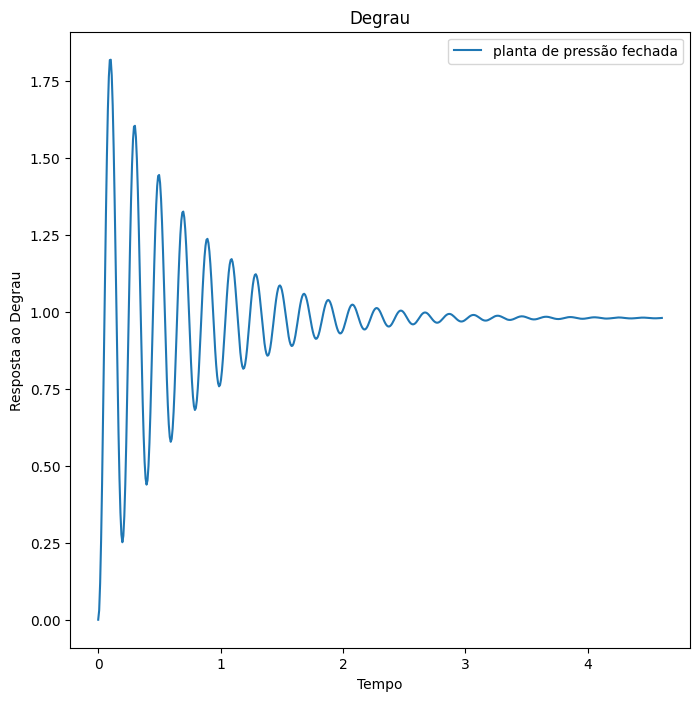

In [3]:
planta_pressao_aberta_ganho_kc = ct.TransferFunction([35.2899 * 28.0796],[1, 3, 20.223])
planta_pressao_fechada_ganho_kc = ct.feedback(planta_pressao_aberta_ganho_kc, 1)
parametros_kc = obter_plot_degrau({'planta de pressão fechada':planta_pressao_fechada_ganho_kc}, amortecimento=0.02)
parametros_kc

# <font style='font-size: 30px;'> Análise lugar das raízes — Compensador de avanço </font> <hr style='line: 2px solid;'>

> 2. Defina qual é o seu par complexo conjugado para produzir suas especificações

Encontre o par de polos complexos e conjugados que pertencem à um lugar das raizes teórico pela qual o lugar das raízes de seu sistema final — fechado — deve passar. Eu estou mirando um $M_p = 0.15$ e $T_s = 0.8$ para garantir os requisitos.

In [79]:
s = obter_conjulgados_dominantes(Mp=0.16, Ts=1, xi=0.8)
s[0]

(-4+3j)

> 3. Posicione um zero abaixo do S objetivo e calcule a defasagem a ser compensada.

O objetivo agora é fixar o zero do nosso compensador na mesma posição real do S objetivo. Tomando essa referência, vamos ver se conseguimos posicionar o polo de maneira a compensar algo. O polo precisa compensar o que o zero adicionar, para que o sistema fique "empatado". Se com essa medida abtrária o polo não tiver nada a compensar, precisaremos modificar um pouco sua posição para poder inserir o polo. 

In [37]:
obter_defasagem_angular_compensador([35.2899 * 28.0796],[1, 3, 20.223], s[0], compensador='avanço', matar_polos=True, delta=4)

1° Polo, -1.5000+4.2395j, faz 132.9° com o S
2° Polo, -1.5000-4.2395j, faz 102.6° com o S
1° Zero, 0.0000+0.0000j, faz 120.0° com o S
2° Zero, -1.5000+4.2395j, faz 132.9° com o S
3° Zero, -1.5000-4.2395j, faz 102.6° com o S
 
 Polo do compensador precisa compensar: 300.0°


> 4. Ache o polo em função do angulo a ser compensado e encontre seu compensador.

Na função abaixo, encontramos 

In [134]:
# obter_compensador_LR([35.2899 * 28.0796], [1, 3, 20.223], s[0], p_c=None, phi_z=None, z_c=(-6+0j), phi_p=34.5) 35.2899 * 
k = 0.01
num, den = obter_compensador_LR2([28.0796], [1, 3, 20.223], polos_add=[1, 1, 0], zeros_add=[k*1, k*3, k*20.223])


 Sua malha sem compensador é:
 
      28.08
-----------------
s^2 + 3 s + 20.22


 Seu compensador é:
 
0.01 s^2 + 0.03 s + 0.2022
--------------------------
         s^2 + s


 Seu sistema compensado é:
 
  0.2808 s^2 + 0.8424 s + 5.679
---------------------------------
s^4 + 4 s^3 + 23.22 s^2 + 20.22 s



> 5. Verifique o lugar das raízes.

In [135]:
malha_aberta  = ct.TransferFunction(num, den)
malha_fechada = ct.feedback(malha_aberta, 1)
malha_fechada

TransferFunction(array([0.280796  , 0.842388  , 5.67853751]), array([ 1.        ,  4.        , 23.503796  , 21.065388  ,  5.67853751]))

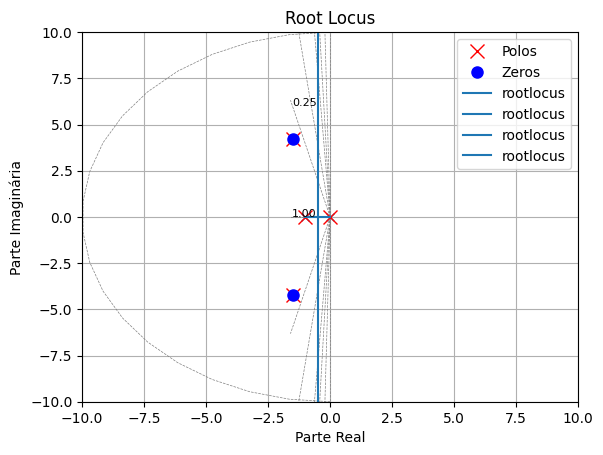


 Polos : 
-1.5000+4.2395j
-1.5000-4.2395j
-1.0000+0.0000j
0.0000+0.0000j

 Zeros : 
-1.5000+4.2395j
-1.5000-4.2395j


In [131]:
obter_lugar_raizes(num, den, l_inf=10, l_sup=10)

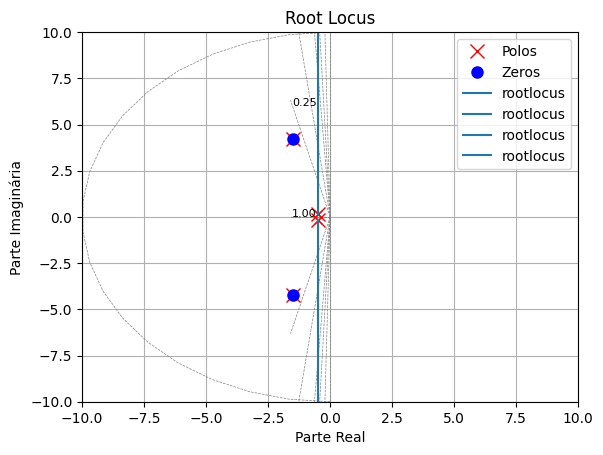


 Polos : 
-1.5000+4.2395j
-1.5000-4.2395j
-0.5000+0.1755j
-0.5000-0.1755j

 Zeros : 
-1.5000+4.2395j
-1.5000-4.2395j


In [136]:
obter_lugar_raizes(malha_fechada.num, malha_fechada.den, l_inf=10, l_sup=10)

> 6. Simule a resposta ao degrau.

In [138]:
obter_z([k*1, k*3, k*20.223], [1, 1, 0], Ts=0.1 )

Coeficientes do compensador discreto:
Numerador: [[ 0.01143388 -0.01808462  0.00857674]]
Denominador: [ 1.        -1.9047619  0.9047619]


                    Valor
Parâmetro                
RiseTime           5.8493
SettlingTime       9.8046
SettlingMin        0.9019
SettlingMax        1.0000
Overshoot          0.0000
Undershoot         0.0000
Peak               0.9989
PeakTime          13.8155
SteadyStateValue   1.0000


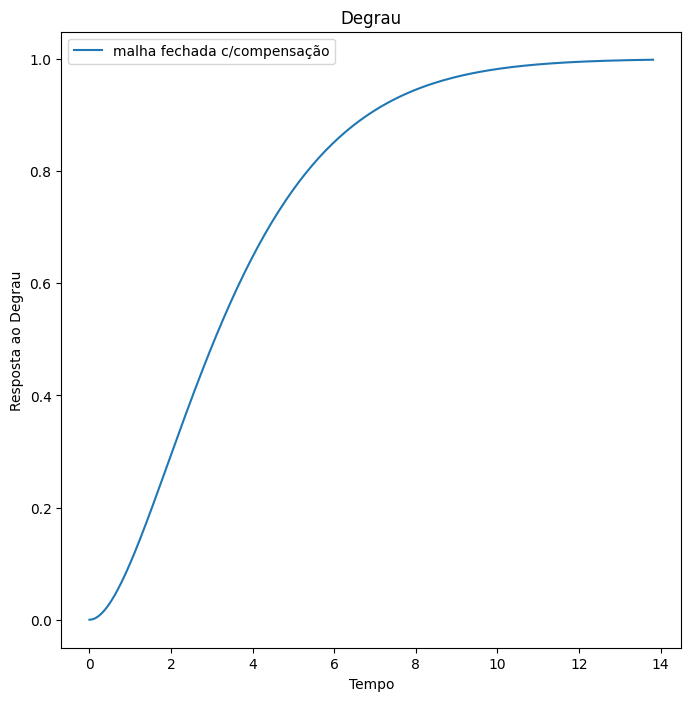

In [137]:
# Plot da resposta ao degrau
obter_plot_degrau({"malha fechada c/compensação":malha_fechada}, amortecimento=0.02)

# <font style='font-size: 30px;'> Análise frequencial — Compensador de avanço </font> <hr style='line: 2px solid;'>

## old

In [104]:
KcG = obter_sistema(zeta=0.3346, wn=4.4971, k=1.3885*35.2899)


         991
---------------------
s^2 + 3.009 s + 20.22

Zeros:
Polos:
-1.5047+4.2379j
-1.5047-4.2379j


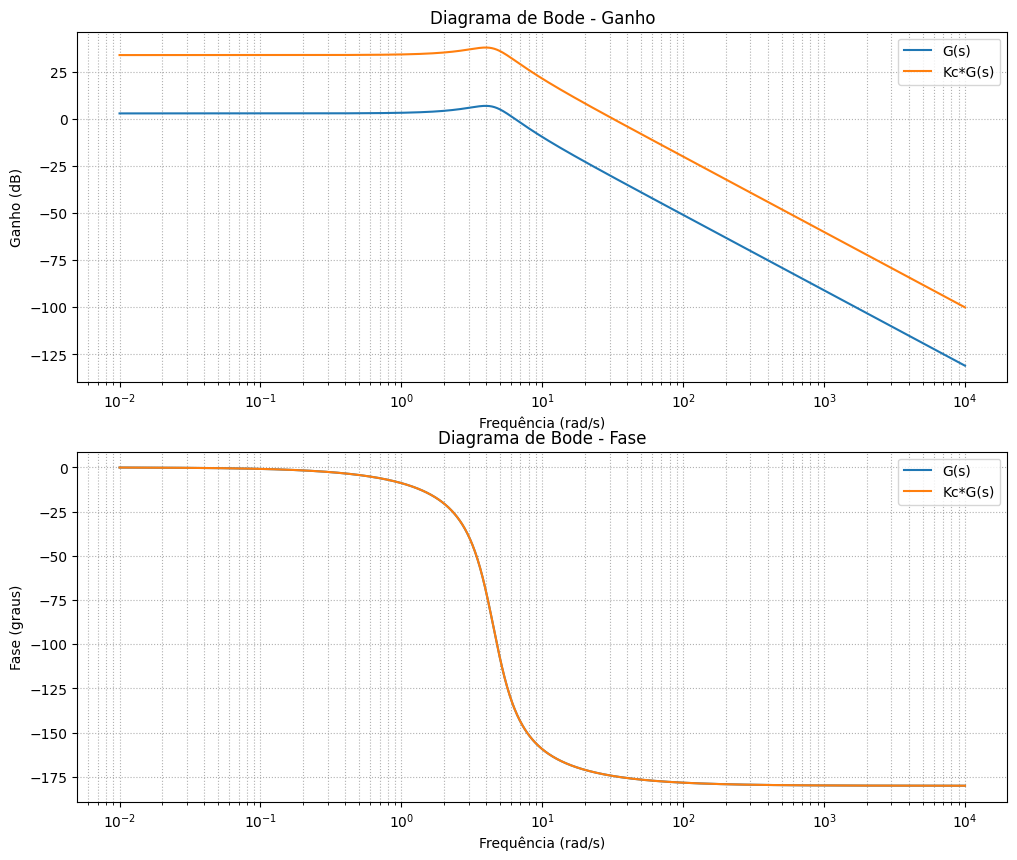

In [105]:
obter_plot_bode({"G(s)":G['scipy'], 'Kc*G(s)':KcG['scipy']})

Observando as *margens* do sistema, podemos ver que a frequência de margem de fase é de $\boxed{31.7267 \frac{rad}{s}}$, cuja fase é -174°

Na literatura (*Ogata, 5°Ed, figura 7.91*), podemos ver que o diagrama polar desse tipo de compensador fornece duas relações interessantes para cálculo, a saber:

$\phi_m$, fase máxima:
$$ \sin{\phi_m} = \frac{1-\alpha}{1+\alpha} $$

$\omega_m$, ganho máxima:
$$ |C(j\omega_m)| = \frac{1}{\sqrt{\alpha}} $$

Considerando nosso requisito de fase, $55° -5.5290°+10°=59.5°$, precisamos que $\phi_m=58.5°$. Logo temos:

$$ sen (53°) = 0.0.7986 = \frac{1-\alpha}{1+\alpha} → \boxed{\alpha = 0.0743} $$

Agora, podemos calcular também o máximo de ganho que nosso compensador pode fornecer:

$$ |C(j\omega_m)| = \frac{1}{\sqrt{8.9305}} →  \boxed{|C(j\omega_m)| = 3.6686 dB}$$

Então, o que queremos é que o modulo do sistema seja $|G(j\omega)| = -3.6686 dB$, e vamos buscar a frequência para esse ganho.

Ou seja, nossa nova frequência de corte será $32.2484 \frac{rad}{s}$, pois se o cruzamento for $\omega_m$, o ganho do compesador vai zerar com o ganho do sistema. Para garantir isso, precisamos encontrar o $T$ que faça isso, assim:

$$\omega_m = \frac{1}{\sqrt{\alpha}T} → \boxed{T = 0.0103}$$

Logo nosso compensador será:

In [3]:
Cav = obter_compensador(alpha=0.0743, T=0.0935, kc=35.2899)


3.3 s + 35.29
--------------
0.006947 s + 1

Zeros:
-10.6952+0.0000j
Polos:
-143.9460+0.0000j


In [94]:
import numpy as np
from scipy.signal import cont2discrete

# Coeficientes do compensador contínuo
num = [3.3, 35.29]
den = [0.006947, 1]

# Tempo de amostragem
Ts = 0.1

# Converte o compensador usando o método de Tustin
num_d, den_d, _ = cont2discrete((num, den), Ts, method='tustin')

# Exibe os coeficientes do compensador discreto
print("Coeficientes do compensador discreto:")
print("Numerador:", num_d)
print("Denominador:", den_d)

Coeficientes do compensador discreto:
Numerador: [[ 88.93356981 -26.96366797]]
Denominador: [1.         0.75601875]


Forma padrão:
**************

              92.66 s + 991
-----------------------------------------
0.006947 s^3 + 1.021 s^2 + 3.15 s + 20.22

Zeros:
-10.6952+0.0000j
Polos:
-143.9460+0.0000j
-1.5047+4.2379j
-1.5047-4.2379j


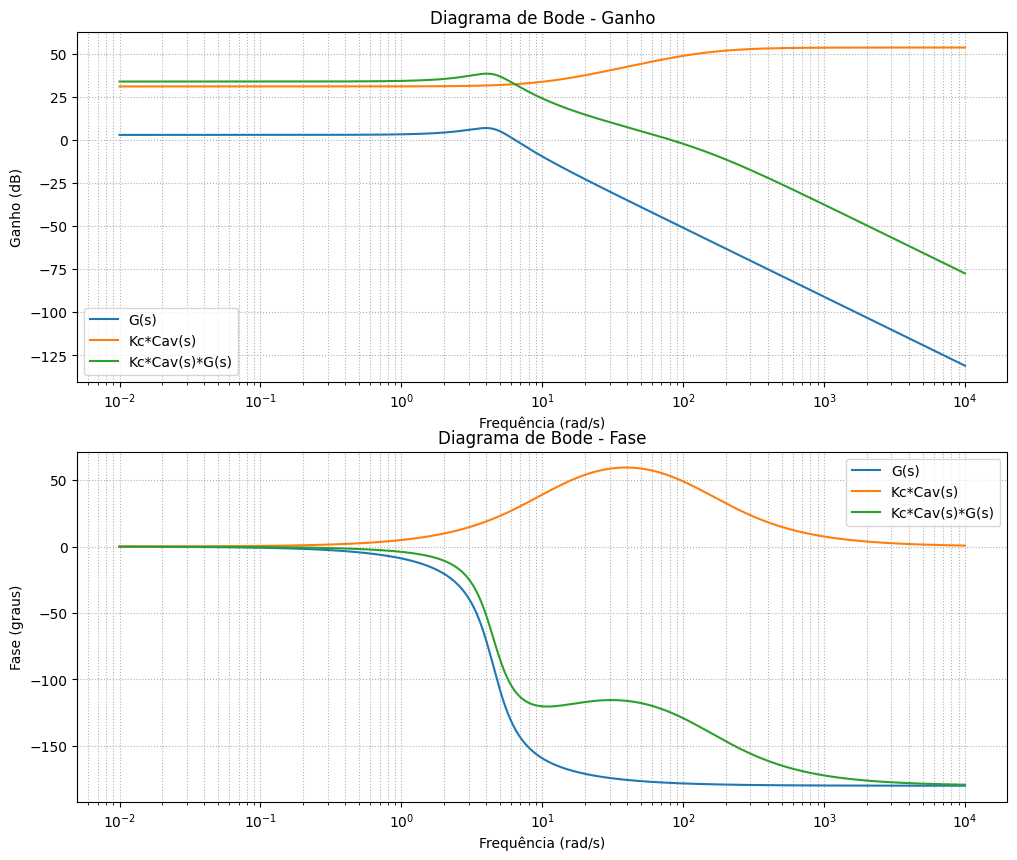

In [107]:
Kc_Cav_G = obter_malha([Cav['control'], G['control']], control=True)
obter_plot_bode({'G(s)':G['scipy'], 'Kc*Cav(s)':Cav['scipy'], 'Kc*Cav(s)*G(s)':Kc_Cav_G['scipy']})

## valendo

In [86]:
G = obter_sistema(zeta=0.3346, wn=4.4971, k=1.3885)

# *35.2899


        28.08
---------------------
s^2 + 3.009 s + 20.22

Zeros:
Polos:
-1.5047+4.2379j
-1.5047-4.2379j


In [107]:
num, den = obter_compensador_FREQ2(num=[28.08], den=[1, 3, 20.22], k_i=0.08)
malha_aberta = ct.TransferFunction(num, den)


 Sua malha sem compensador é:
 
      28.08
-----------------
s^2 + 3 s + 20.22


 Seu compensador é:
 
0.08
----
 s


 Seu sistema compensado é:
 
        2.246
---------------------
s^3 + 3 s^2 + 20.22 s



In [108]:
malha_fechada_avanco = obter_malha([malha_aberta], control=True, close=True) # obter cascata da malha e fechar ela


Forma padrão:
**************

            2.246
-----------------------------
s^3 + 3 s^2 + 20.22 s + 2.246

Zeros:
Polos:
-1.4435+4.2202j
-1.4435-4.2202j
-0.1129+0.0000j


,Frequência (rad/s),Fase (graus),Ganho (dB)
valores,6.805074,-232.408468,-39.977405


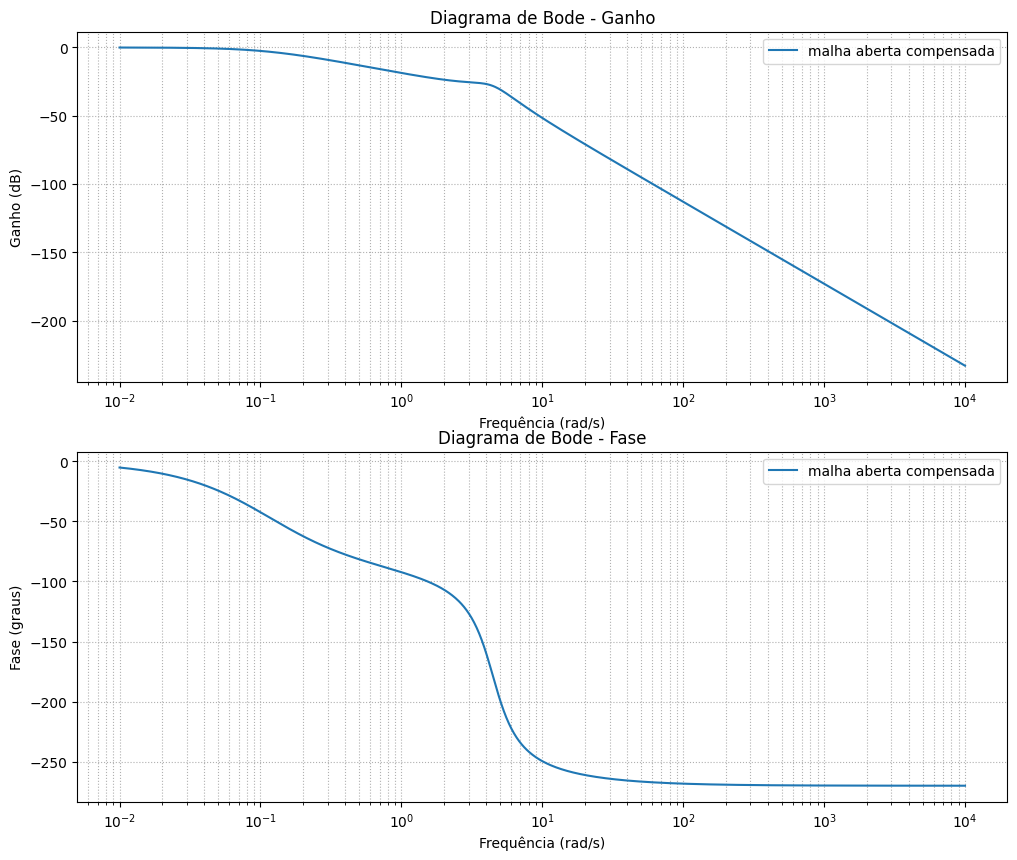

In [109]:
obter_plot_bode({'malha aberta compensada':malha_fechada_avanco['scipy']})
obter_valor_bode(malha_fechada_avanco['scipy'], criterio='ganho', valor=-40, resolucao=1000)

In [115]:
obter_z([0.08], [1,0], Ts=0.1, )

Coeficientes do compensador discreto:
Numerador: [[0.004 0.004]]
Denominador: [ 1. -1.]


                    Valor
Parâmetro                
RiseTime          19.4903
SettlingTime      34.8121
SettlingMin        0.9003
SettlingMax        1.0000
Overshoot          0.0000
Undershoot         0.0000
Peak               0.9990
PeakTime          61.1747
SteadyStateValue   1.0000


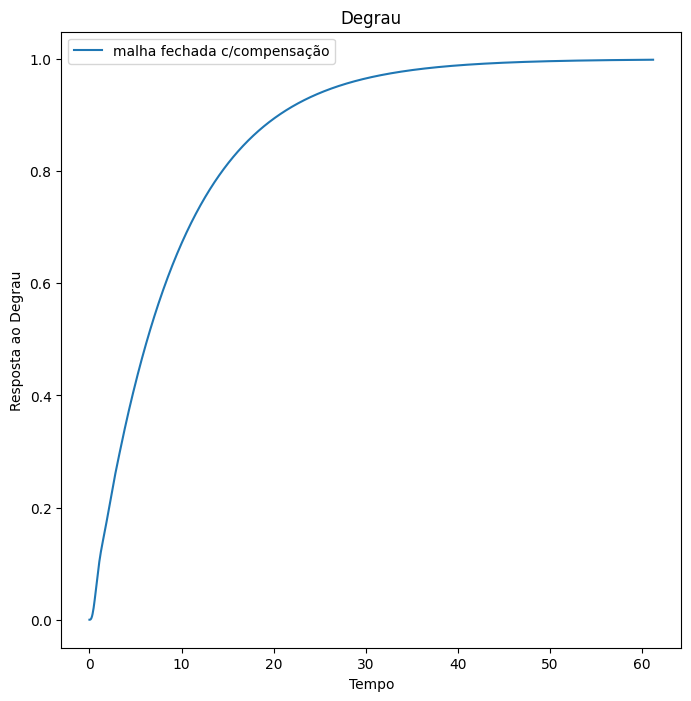

In [110]:
# Plot da resposta ao degrau
obter_plot_degrau({"malha fechada c/compensação":malha_fechada_avanco['control']}, amortecimento=0.02)

# <font style='font-size: 30px;'> Funções </font> <hr style='line: 2px solid;'>

In [114]:
# Imports

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import scipy.signal as signal
import numpy as np
import pandas as pd
import control as ct
import scipy as sp
import warnings
import cmath
from scipy.signal import cont2discrete
import sympy


# Análise LR

def obter_conjulgados_dominantes(Mp, Ts, xi=None):
    """
    Função para obter o compensador de avanço de um sistema.
    
    Parâmetros:
    - Mp : sobressinal desejado no caso de sistemas de 1º ordem
    - Ts : tempo de acomodação desejado
    - xi : se for passado, a função ignorará Mp. Usado para sistemas de 2º ordem
    
    Retorno:
    - dois polos complexos e conjulgados que passam nas especificações
    """

    if xi == None:
        xi = -np.log(Mp) / np.sqrt(np.pi**2 + np.log(Mp)**2)
    wn = 4 / (Ts * xi)
    wd = wn * np.sqrt(1 - xi**2)
    pole1 = complex(-xi*wn, wd)
    pole2 = complex(-xi*wn, -wd)
    pole1 = np.round(pole1, decimals=4)  # Arredondar o polo1 para 3 casas decimais
    pole2 = np.round(pole2, decimals=4)  # Arredondar o polo2 para 3 casas decimais
    return [pole1, pole2]

def obter_defasagem_angular_compensador(num, den, s, delta=0, compensador='avanço', matar_polos=False):
    """
    Função para obter o compensador de avanço ou atraso de um sistema.

    Parâmetros:
    - num: array numerador do seu sistema
    - den: array denominador do seu sistema
    - s: 1 polo complexo de referência
    - delta (opcional): ajuste da posição do zero ou polo de referência
    - compensador (opcional): tipo de compensador, 'avanço' ou 'atraso'

    Retorno:
    - dois polos complexos e conjugados que passam nas especificações
    """

    # Obter os polos e zeros da função de transferência
    polos = np.roots(den)
    zeros = np.roots(num)

    # Adicionar o zero ou polo de referência
    if compensador == 'avanço':
        zeros = np.append(zeros, s.real+delta)
    elif compensador == 'atraso':
        polos = np.append(polos,complex(-0.01+delta))

    # Cancelar os polos, se necessário
    if matar_polos:
        zeros = np.append(zeros, polos)
    
    # Calcular a defasagem angular
    phi = 180

    # Calcular contribuição dos polos
    i = 1
    for polo in polos:
        angulo = np.angle(s - polo, deg=True)
        print(f"{i}° Polo, {polo:.4f}, faz {angulo:.1f}° com o S")
        phi -= angulo
        i += 1

    # Calcular contribuição dos zeros
    i = 1
    for zero in zeros:
        angulo = np.angle(s - zero, deg=True)
        print(f"{i}° Zero, {zero:.4f}, faz {angulo:.1f}° com o S")
        phi += angulo
        i += 1

    print(f" \n Polo do compensador precisa compensar: {phi:.1f}°")

def obter_compensador_LR(num, den, s, p_c=None, phi_z=None, z_c=None, phi_p=None):
    """
    Função para obter o compensador de avanço ou atraso de um sistema.
    
    Parâmetros:
    - k: ganho do seu controlador
    - num: lista dos coeficientes do numerador da função de transferência
    - den: lista dos coeficientes do denominador da função de transferência
    - s: número complexo alvo para referência
    - p_c: polo do compensador
    - z_c: zero do compensador
    - phi_p: ângulo interno que polo do compensador faz com s
    - phi_z: ângulo interno que zero do compensador faz com s
    
    Retorno:
    - Prints do compensador, sistema não compensado e sistema compensado.
    
    """

    if p_c is not None:
        # Encontrar zero (compensador de atraso)
        z_c = (s.imag/np.tan(phi_z * (np.pi/180))) - s.real
        print(f"\n Seu zero está em: {(z_c.real):.4f}")
    elif z_c is not None:
        # Encontrar polo (compensador de avanço)
        p_c = (s.imag/np.tan(phi_p * (np.pi/180))) - s.real
        print(f"\n Seu polo está em: {(p_c.real):.4f}")
    else: raise ("Não pode haver polo e zero nulo ao mesmo tempo. Escolha um")

    # # Valorando a função transferência para s
    # den_eval = np.polyval(den, s)
    # den_eval = np.abs(den_eval)
    # num_eval = np.polyval(num, s)
    # num_eval = np.abs(num_eval)

    # # Valorando o compensador para s
    # num_eval_comp = np.abs(s + np.abs(z_c.real))
    # den_eval_comp = np.abs(s + np.abs(p_c.real))

    # den_eval = den_eval_comp * den_eval
    # num_eval = num_eval_comp * num_eval

    # Obter polos e zeros da função de transferência
    polos = ct.pole(ct.TransferFunction(num, den))
    zeros = ct.zero(ct.TransferFunction(num, den))
    
    # Calcular o módulo dos termos
    num_eval = 1
    for zero in zeros:
        num_eval *= np.abs(zero + s)

    den_eval = 1
    for polo in polos:
        den_eval *= np.abs(polo + s)

    # Verificando condição de módulo
    k_c = den_eval/num_eval
    print(f"\n Você precisa multiplicar por: {(k_c):.4f} para satisfazer a condição de módulo")
    k_c = 0.76

    # Construção da função de transferência do compensador
    compensador = ct.TransferFunction([k_c, k_c*np.abs(z_c.real)], [1, np.abs(p_c.real)])
    sistema = ct.TransferFunction(num, den)
    sistema_compensado = compensador * sistema
    
    # Imprimir a função de transferência do compensador e os sistemas
    print(f"\n Seu compensador é:\n {compensador}")
    print(f"\n Sua malha sem compensador é:\n {sistema}")
    print(f"\n Sua malha com compensador é:\n {sistema_compensado}")

def obter_compensador_LR2(num, den, polos_add=None, zeros_add=None):

    sistema = ct.TransferFunction(num, den)
    compensador = ct.TransferFunction(zeros_add, polos_add)
    sistema_compensado = sistema * compensador

    # Imprimir a função de transferência do compensador e os sistemas
    print(f"\n Sua malha sem compensador é:\n {sistema}")
    print(f"\n Seu compensador é:\n {compensador}")
    print(f"\n Seu sistema compensado é:\n {sistema_compensado}")

    # print(ct.zpk(sistema_compensado.num, sistema_compensado.den, 1, 'zpk'))

    return sistema_compensado.num, sistema_compensado.den
    
def obter_lugar_raizes(num, den, l_inf=10, l_sup=10):
    
    system = ct.TransferFunction(num, den)
    poles, zeros = ct.pzmap(system, plot=False)
    
    if len(poles) == 0:
        print("Não há polos no sistema.")
        return

    fig, ax = plt.subplots()

    # rlist, klist = ct.root_locus(system, plot=False)
    rlist, klist = ct.root_locus(system, plot=True, ax=ax)

    ax.plot(np.real(poles), np.imag(poles), 'rx', markersize=10, label='Polos')
    ax.plot(np.real(zeros), np.imag(zeros), 'bo', markersize=8, label='Zeros')

    ax.set_xlim([-l_inf, l_sup])  # Define o limite do eixo x
    ax.set_ylim([-l_inf, l_sup])  # Define o limite do eixo y

    plt.legend()
    plt.xlabel('Parte Real')
    plt.ylabel('Parte Imaginária')
    plt.grid(True)
    plt.show()

    print("\n Polos : ")
    for polo in poles:
        print(f"{polo:.4f}")
    
    print("\n Zeros : ")
    for zero in zeros:
        print(f"{zero:.4f}")

    #print("\n Ganho crítico (ganho no ponto de ruptura):", np.abs(klist[-1]))

def obter_plot_degrau(transfer_functions, amortecimento=0.02):
    
    fig, ax = plt.subplots(figsize=(8, 8))

    for i, (name, transfer_function) in enumerate(transfer_functions.items()):
        
        # obter resposta ao degrau unitário
        tempo, resposta = ct.step_response(transfer_function)
        ax.plot(tempo, resposta, label=name)

        # obter informações
        info_sistema = ct.step_info(transfer_function, SettlingTimeThreshold=amortecimento)
        df_sistema = pd.DataFrame.from_dict(info_sistema, orient='index', columns=[name])
        df_sistema.index.name = 'Parâmetro'

        # Adicionar erro
        e_ss_atual = float(f"{1 - float(df_sistema.at['SteadyStateValue', name])}")
        df_adicional = pd.DataFrame({name: [e_ss_atual]}, index=['Erro(%)'])
        df_sistema = pd.concat([df_sistema, df_adicional])
        
        # arredondar para 4 decimais
        df_sistema = df_sistema.applymap(lambda x: f'{x:.4f}')
        print(f"\n {df_sistema}")

    ax.set_xlabel('Tempo')
    ax.set_ylabel('Resposta ao Degrau')
    ax.set_title('Degrau')
    ax.grid(True)
    ax.legend()

    # plt.tight_layout()
    plt.show()


# Análise frequencial

def obter_sistema(zeta=None, wn=None, k=1, num=None, den=None):
    if num is not None and den is not None:
        sc_tf = ct.TransferFunction(k*num, den)
        ct_tf = ct.TransferFunction(k*num, den)
    elif zeta is not None and wn is not None and k is not None:
        num = [k*wn**2]
        den = [1, 2*zeta*wn, wn**2]
        sc_tf = signal.TransferFunction(num, den)
        ct_tf = ct.TransferFunction(num, den)
    else:
        raise ValueError("É necessário fornecer os coeficientes da função de segunda ordem ou os coeficientes num e den.")

    # gm, pm, wg, wp = ct.margin(ct_tf)
    # df = pd.DataFrame(columns=['Margem de Ganho (dB)', 'Margem de Fase (graus)', 'Frequência de Margem de Ganho (rad/s)', 'Frequência de Margem de Fase (rad/s)'])
    # df.loc['Sistema'] = [gm, pm, wg, wp]
    
    print(ct_tf)
    print("Zeros:")
    zeros = np.round(ct.zero(ct_tf), 4)
    for zero in zeros:
        print(f"{zero.real:+.4f}{zero.imag:+.4f}j")
    print("Polos:")
    polos = np.round(ct.pole(ct_tf), 4)
    for polo in polos:
        print(f"{polo.real:+.4f}{polo.imag:+.4f}j")
    
    # return {"scipy":sc_tf, "control":ct_tf, "dados":df}
    return {"scipy":sc_tf, "control":ct_tf}

def obter_compensador_FREQ(alpha, T, kc):
    
    num = [kc*T, kc*1]
    den = [alpha * T, 1]
    sc_tf = signal.TransferFunction(num, den)
    ct_tf = ct.TransferFunction(num, den)
    gm, pm, wg, wp = ct.margin(ct_tf)

    df = pd.DataFrame(columns=['Margem de Ganho (dB)', 'Margem de Fase (graus)', 'Frequência de Margem de Ganho (rad/s)', 'Frequência de Margem de Fase (rad/s)'])
    if alpha > 1:   df.loc['Compensador de atraso'] = [gm, pm, wg, wp]
    elif alpha < 1: df.loc['Compensador de avanço'] = [gm, pm, wg, wp]
    else:           df.loc['Não é compensador'] = [gm, pm, wg, wp]
    print(ct_tf)
    print("Zeros:")
    zeros = np.round(ct.zero(ct_tf), 4)
    for zero in zeros:
        print(f"{zero.real:+.4f}{zero.imag:+.4f}j")
    print("Polos:")
    polos = np.round(ct.pole(ct_tf), 4)
    for polo in polos:
        print(f"{polo.real:+.4f}{polo.imag:+.4f}j")

    return {"scipy":sc_tf, "control":ct_tf, "dados":df}

def obter_compensador_FREQ2(num, den, k_i):

    sistema = ct.TransferFunction(num, den)
    compensador = ct.TransferFunction([k_i],[1, 0])
    sistema_compensado = sistema * compensador

    # Imprimir a função de transferência do compensador e os sistemas
    print(f"\n Sua malha sem compensador é:\n {sistema}")
    print(f"\n Seu compensador é:\n {compensador}")
    print(f"\n Seu sistema compensado é:\n {sistema_compensado}")

    # print(ct.zpk(sistema_compensado.num, sistema_compensado.den, 1, 'zpk'))

    return sistema_compensado.num, sistema_compensado.den

def obter_malha(lista_tf, scipy=False, control=False, close=False):


    if scipy:

        raise ValueError("Função bloqueada, não utilize scipy!")
        # num_total = [1]
        # den_total = [1]

        # for tf in lista_tf:
        #     num_total = np.convolve(num_total, tf.num) # convolui o numerador
        #     den_total = np.convolve(den_total, tf.den) # convolui o denominador

        # tf_scipy = signal.TransferFunction(num_total, den_total) # obtem função objeto função de transferência no scipy
        # tf_control = ct.TransferFunction(num_total, den_total) # obtem função objeto função de transferência no control

    if control:
        tf_control = ct.TransferFunction(1, 1)  # Inicializa a função de transferência da malha como 1 (sistema vazio)
        for tf in lista_tf:
            tf_control *= tf  # Multiplica a função de transferência da malha pelo sistema atual
        tf_scipy = tf_control.returnScipySignalLTI()
        tf_scipy = tf_scipy[0][0]

    if close:
        tf_control = ct.feedback(tf_control)  # Realizar o feedback no objeto do Control
        tf_scipy = tf_control.returnScipySignalLTI()
        tf_scipy = tf_scipy[0][0]
    
    print("Forma padrão:")
    print("**************")
    print(tf_control)

    print("Zeros:")
    zeros = np.round(ct.zero(tf_control), 4)
    for zero in zeros:
        print(f"{zero.real:+.4f}{zero.imag:+.4f}j")
    
    print("Polos:")
    polos = np.round(ct.pole(tf_control), 4)
    for polo in polos:
        print(f"{polo.real:+.4f}{polo.imag:+.4f}j")

    return {'scipy':tf_scipy, 'control':tf_control}

def obter_parametros_sistema(num=None, den=None, sys=None, acomodacao=0.02):
    if sys is not None:
        sistema = sys
    elif num is not None and den is not None:
        sistema = ct.TransferFunction(num, den)
    else:
        raise ValueError("É necessário fornecer o sistema ou o numerador e o denominador.")
    info_sistema = ct.step_info(sistema, SettlingTimeThreshold=acomodacao)
    df_sistema = pd.DataFrame.from_dict(info_sistema, orient='index', columns=['Valor'])
    df_sistema.index.name = 'Parâmetro'
    df_sistema = df_sistema.applymap(lambda x: f'{x:.4f}')
    e_ss_atual = float(f"{1 - float(df_sistema.at['SteadyStateValue', 'Valor']):.4f}")
    df_adicional = pd.DataFrame({'Valor': [e_ss_atual]}, index=['Erro(%)'])
    df_sistema = pd.concat([df_sistema, df_adicional])
    # df_sistema = df_sistema.drop(['SettlingMin', 'SettlingMax', 'Undershoot'])
    return df_sistema

def obter_valor_bode(sistema, criterio, valor, resolucao):

    w = np.logspace(-2, 3, num=resolucao)  # Definir o array de frequências com mais pontos
    omega, mag, phase = signal.bode(sistema, w=w)   # produz a simulação de Bode

    # verifica qual critério o usuário escolheu e retorna o valores com base nele
    if criterio == "frequencia":
        indice = np.argmin(np.abs(omega - valor))
    elif criterio == "fase":
        valor_rad = np.deg2rad(valor)
        indice = np.argmin(np.abs(phase - valor))
    elif criterio == "ganho":
        indice = np.argmin(np.abs(mag - valor))
    frequencia = omega[indice]
    fase = phase[indice]
    ganho = mag[indice]

    # produz uma tabela (Dataframe) para melhor visualização dos resultados
    df = pd.DataFrame({"Frequência (rad/s)": [frequencia],"Fase (graus)": [fase],"Ganho (dB)": [ganho]}, index=["valores"])

    return df

def obter_plot_bode(transfer_functions):
    
    # Frequências para o cálculo do Bode
    w = np.logspace(-2, 4, num=1000)

    # Criação dos subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    for name, transfer_function in transfer_functions.items():

        # Obter os dados do diagrama de Bode
        omega, mag, phase = signal.bode(transfer_function,w=w)

        # Plot do diagrama de ganho
        ax1.semilogx(omega, mag, label=name)

        # Plot do diagrama de fase
        ax2.semilogx(omega, phase, label=name)

        # 20*np.log10(mag)
        # phase*(180/np.pi)

    ax1.set_xlabel('Frequência (rad/s)')
    ax1.set_ylabel('Ganho (dB)')
    ax1.set_title('Diagrama de Bode - Ganho')
    ax1.grid(True, which='both', linestyle='dotted')
    ax1.legend()

    ax2.set_xlabel('Frequência (rad/s)')
    ax2.set_ylabel('Fase (graus)')
    ax2.set_title('Diagrama de Bode - Fase')
    ax2.grid(True, which='both', linestyle='dotted')
    ax2.legend()

    # Retorna a figura
    # return fig

def obter_plot_nyquist(transfer_functions, colors=['red', 'blue', 'green']):
    # Frequências para o cálculo do Nyquist
    w = np.logspace(-2, 4, num=1000)

    # Criação do plot padrão
    fig, ax = plt.subplots(figsize=(8, 8))

    for i, (name, transfer_function) in enumerate(transfer_functions.items()):
        # Cálculo do diagrama de Nyquist
        response = ct.nyquist(transfer_function, omega=w, color=colors[i])

        # Plot dos pontos do diagrama de Nyquist com cor específica
        ax.scatter(response.real, response.imag, color=colors[i], label=name)

    ax.set_xlabel('Parte Real')
    ax.set_ylabel('Parte Imaginária')
    ax.set_title('Diagrama de Nyquist')
    ax.grid(True, linestyle='dotted')
    ax.legend()
    plt.show()

    # Criação do plot com aproximação nos limites
    fig2, ax2 = plt.subplots(figsize=(8, 8))

    for i, (name, transfer_function) in enumerate(transfer_functions.items()):
        # Cálculo do diagrama de Nyquist
        response = ct.nyquist(transfer_function, omega=w, color=colors[i])

        # Plot dos pontos do diagrama de Nyquist com cor específica e limites de exibição
        ax2.scatter(response.real, response.imag, color=colors[i], label=name)

    ax2.set_xlabel('Parte Real')
    ax2.set_ylabel('Parte Imaginária')
    ax2.set_title('Diagrama de Nyquist (Aproximação nos Limites)')
    ax2.grid(True, linestyle='dotted')
    ax2.set_xlim([-2, 2])  # Limites no eixo x
    ax2.set_ylim([-2, 2])  # Limites no eixo y
    ax2.legend()
    plt.show()

def obter_plot_degrau(transfer_functions, amortecimento=0.02):
    
    fig, ax = plt.subplots(figsize=(8, 8))

    for i, (name, transfer_function) in enumerate(transfer_functions.items()):
        
        info_sistema = ct.step_info(transfer_function, SettlingTimeThreshold=amortecimento)
        df_sistema = pd.DataFrame.from_dict(info_sistema, orient='index', columns=['Valor'])
        df_sistema.index.name = 'Parâmetro'
        df_sistema = df_sistema.applymap(lambda x: f'{x:.4f}')

        tempo, resposta = ct.step_response(transfer_function)
        ax.plot(tempo, resposta, label=name)
        print(df_sistema)

    ax.set_xlabel('Tempo')
    ax.set_ylabel('Resposta ao Degrau')
    ax.set_title('Degrau')
    ax.legend()

    # plt.tight_layout()
    plt.show()

def obter_informacoes_bode(num=[],den=[], resolucao=1000, close=False):

    # Simulação de Bode com scipy
    w = np.logspace(-2, 3, num=resolucao)
    tf_scipy = signal.TransferFunction(num, den)
    omega, mag, phase = signal.bode(tf_scipy, w=w)

    # Frequências para o cálculo do Bode
    w = np.logspace(-2, 2, num=1000)
    tf_control = ct.TransferFunction(num, den, )
    mag, phase, omega = ct.bode(tf_control, deg = True, Hz=False, dB=True, plot=False)


    # Pico de ressonância e sua frequência
    indice_pico = np.argmax(mag)
    pico_ressonancia = mag[indice_pico]
    frequencia_pico = omega[indice_pico]

    # Ganho em baixas frequências
    ganho_baixas_frequencias = mag[0]

    # Banda de passagem
    indice_ganho_nulo = np.argmin(np.abs(mag))
    indice_3db = np.where(mag >= ganho_baixas_frequencias - 3)[0][0] # castrucci. fig 5-40
    frequencia_corte = omega[indice_3db]
    banda_passagem = frequencia_corte - frequencia_pico

    # Margens de ganho e fase
    gm, pm, wg, wp = ct.margin(tf_control)

    if close:
        data = {
        "Pico de ressonância (dB)": round(pico_ressonancia, 4),
        "Ganho em baixas frequências (dB)": round(ganho_baixas_frequencias, 4),
        "Margem de Ganho (dB)": round(gm, 4),
        "Margem de Fase (graus)": round(pm, 4),
        }
    else:
        data = {
            "Pico de ressonância (dB)": round(pico_ressonancia, 4),
            "Frequência do pico de ressonância (rad/s)": round(frequencia_pico, 4),
            "Ganho em baixas frequências (dB)": round(ganho_baixas_frequencias, 4),
            "Banda de passagem (rad/s) e corte": round(banda_passagem, 4),
            "Margem de Ganho (dB)": round(gm, 4),
            "Margem de Fase (graus)": round(pm, 4),
            "Frequência de Margem de Ganho (rad/s)": round(wg, 4),
            "Frequência de Margem de Fase (rad/s)": round(wp, 4),
        }

    df = pd.DataFrame(data, index=[0])
    return df

def obter_z(num, den, Ts):

    # Converte o compensador usando o método de Tustin
    num_d, den_d, _ = cont2discrete((num, den), Ts, method='tustin')

    # Exibe os coeficientes do compensador discreto
    print("Coeficientes do compensador discreto:")
    print("Numerador:", num_d)
    print("Denominador:", den_d)

    # # Criando símbolos
    # z = sp.symbols('z')
    # num_expr = sum(num_d[i] * z**(-i) for i in range(len(num_d)))
    # den_expr = sum(den_d[i] * z**(-i) for i in range(len(den_d)))

    # # Exibindo a expressão da função de transferência discreta
    # z_expr = num_expr / den_expr
    # print("Expressão da função de transferência discreta:")
    # print(sympy.pretty(z_expr))
